In [54]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [55]:
tesla_stocks = pd.read_csv('/home/jovyan/courses-txg/RNN/part2/data/tesla_stocks.csv')

In [56]:
#資料共有六個資訊，日期、開盤、當日最高、當日最低、收盤、成交量
tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,4-Aug-14,234.38,240.50,233.27,238.52,5967406
1,5-Aug-14,237.47,242.99,235.69,238.49,5388581
2,6-Aug-14,238.90,251.42,238.58,248.93,9249265
3,7-Aug-14,250.12,256.69,249.12,252.39,7478926
4,8-Aug-14,251.16,251.76,246.50,248.13,5099061


In [89]:
#簡化預測複雜度，我們只使用收盤價預測
data_to_use = tesla_stocks['Close'].values

In [90]:
#資料共有756天成交紀錄
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


# Preprocessing

In [91]:
scaler = StandardScaler()

In [94]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

In [95]:
print("std: ", scaled_dataset.std())
print("mean: ", scaled_dataset.mean())

std:  0.9999999999999999
mean:  4.69935671799008e-16


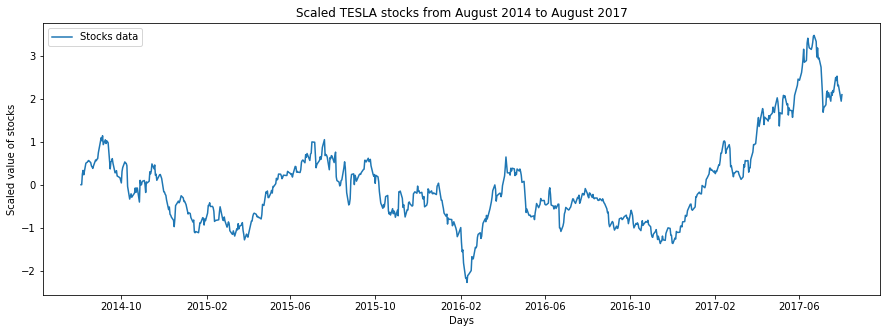

In [62]:
tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(15,5), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(tesla_stocks.Date, scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

# Conifg

In [63]:
#參數設定
learning_rate=0.001
batch_size=8
epochs = 200
hidden_layer_size=512
number_of_layers=1
dropout=True
dropout_rate=0.8
number_of_classes=1
window_size=7

In [64]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i: i + window_size])
        y.append(data[i + window_size])
        i += 1
        
    assert len(X) == len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [66]:
X, y = window_data(scaled_dataset, window_size)

#### Step 1.3 Creating Training and Testing sets

In [13]:
X_train = np.array(X[: 700])
X_test = np.array(X[700: ])

y_train = np.array(y[: 700])
y_test = np.array(y[700: ])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (49, 7, 1)
y_test size: (49, 1)


### Let's create the RNN

In [14]:
import tensorflow as tf

In [15]:
def LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout=True, dropout_rate=0.8):
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer] * number_of_layers)
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

def output_layer(lstm_output, out_size):
    x = lstm_output[:, -1, :]
    output = tf.layers.dense(inputs=x, units=out_size)
    
    return output

# RNN及LSTM會有梯度爆炸的問題，因此若斜率超過+-5則clip到+-5之內
def opt_loss(logits, targets, learning_rate):
    
    loss = tf.reduce_mean(tf.pow((targets - logits), 2)) / batch_size
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = optimizer.compute_gradients(loss)
    
    capped_gradients = [(tf.clip_by_value(grad, -5, 5), var) for grad, var in gradients if grad is not None]
#     for i, j  in gradients:
#         print(i)
#         print('-'*10)
#         print(j)
#         print('*'*10)
    
    train_optimizer = optimizer.apply_gradients(capped_gradients)
    
    return loss, train_optimizer

### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行

In [21]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    with tf.name_scope('input'):
        inputs = tf.placeholder(tf.float32, shape=[None, window_size, 1], name='input_data')
        targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')
        keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')
        
    with tf.variable_scope('lstm_layer'):
        cell, init_state = LSTM_cell(hidden_layer_size, tf.shape(inputs)[0], number_of_layers, dropout, keep_prob)
        outputs, states = tf.nn.dynamic_rnn(cell, inputs=inputs, initial_state=init_state)
    
    with tf.variable_scope('output_layer'):
        logits = output_layer(outputs, number_of_classes)
        
    with tf.name_scope('loss_and_opti'):
        loss, opti = opt_loss(logits, targets, learning_rate)
    
    init = tf.global_variables_initializer()

In [22]:
sess.run(init)

In [23]:
for i in range(epochs):
    k = 0
    epoch_loss = []
    while (k + batch_size) <= len(X_train):
        X_batch = X_train[k: k + batch_size]
        y_batch = y_train[k: k + batch_size]
        batch_loss, _ = sess.run([loss, opti], feed_dict={inputs: X_batch, targets: y_batch, keep_prob: 0.8})
        epoch_loss.append(batch_loss)
        k += batch_size
    if i % 30 == 0:
        print('Epoch {}/{}'.format(i, epochs), 'Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200 Current loss: 0.01340430323034525
Epoch 30/200 Current loss: 0.0027686532121151686
Epoch 60/200 Current loss: 0.002687611384317279
Epoch 90/200 Current loss: 0.0025370740331709385
Epoch 120/200 Current loss: 0.0025682745035737753
Epoch 150/200 Current loss: 0.0025853037368506193
Epoch 180/200 Current loss: 0.0025221442338079214


In [39]:
training_set_pred = np.array([])
for i in range(len(X_train)):
    o = sess.run(logits, feed_dict={inputs: X_train[i: i+1], keep_prob: 1.0})
    training_set_pred = np.append(training_set_pred, o)


In [41]:
testing_set_pred = np.array([])
for i in range(len(X_test)):
    o = sess.run(logits, feed_dict={inputs: X_test[i: i+1], keep_prob: 1.0})
    testing_set_pred = np.append(testing_set_pred, o)

In [53]:
training = [None] * window_size
for i in range(len(X_train)):
    training.append(training_set_pred[i])
    
test = [None] * (window_size + len(X_train))
testing_loss = 0
for i in range(len(X_test)):
    test.append(testing_set_pred[i])
    testing_loss += (testing_set_pred[i] - y_test[i]) ** 2
    training.append(None)

print('testing loss: ', testing_loss/len(X_test))

testing loss:  [0.08562694]


### Plotting predictions from the network

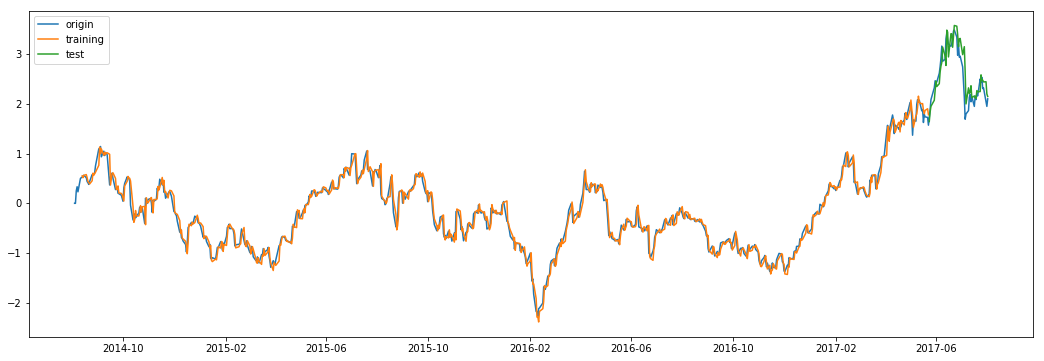

In [58]:
plt.figure(figsize=(18, 6))

plt.plot(tesla_stocks.Date, scaled_dataset, label='origin')
plt.plot(tesla_stocks.Date, training, label='training')
plt.plot(tesla_stocks.Date, test, label='test')
plt.legend()
plt.show()